In [17]:
import kwant
import numpy as np
import tinyarray
import types
import matplotlib.pyplot as plt
import scipy


# Obliczenia prowadze sa w jednostkach atomowych e=h=me=1. Tutaj definiuje wspolczynniki konwersji.
def eV2au(energy):  # eV -> j.a
    return energy * 0.03674932587122423


def nm2au(length):  # nm -> j.a
    return length * 18.89726133921252


def T2au(length):  # nm -> j.a
    return length * 4.254382e-6


I = tinyarray.array([[1, 0], [0, 1]])

I_offdiag = tinyarray.array([[0, 1], [1, 0]])

sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

In [18]:
def make_lao_sto_qd(qd_physical_params, qd_numerical_params):

    m = qd_physical_params.m
    dx = qd_physical_params.dx
    tl = qd_physical_params.tl
    th = qd_physical_params.th
    td = qd_physical_params.td
    dso = qd_physical_params.dso
    drso = qd_physical_params.drso
    dE = qd_physical_params.dE
    g = qd_physical_params.g
    eps_r = qd_physical_params.eps_r

    n_orbitals = 6

    def potential(x, y):
        return 0.5 * qd_physical_params.m * qd_physical_params.omega**2 * (x**2 + y**2)

    def onsite(site):
        (x, y) = site.pos
        H_0 = np.array(
            [
                [4 * tl - dE + potential(x, y), 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 4 * tl - dE + potential(x, y), 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 2 * tl + 2 * th + potential(x, y), 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 2 * tl + 2 * th + potential(x, y), 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 2 * tl + 2 * th + potential(x, y), 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 2 * tl + 2 * th + potential(x, y)],
            ]
        )
        H_so = (
            dso
            / 3.0
            * np.array(
                [
                    [0, 0, 0, 1j, 0, -1],
                    [0, 0, 1j, 0, 1, 0],
                    [0, -1j, 0, 0, 1j, 0],
                    [-1j, 0, 0, 0, 0, -1j],
                    [0, 1, -1j, 0, 0, 0],
                    [-1, 0, 0, 1j, 0, 0],
                ]
            )
        )
        H_B = np.zeros((n_orbitals, n_orbitals), dtype=complex)  # not used yet
        return H_0 + H_so + H_B

    def hopping_x(site_1, site_2):
        (x_1, y_1) = site_1.pos
        (x_2, y_2) = site_2.pos
        H_x = np.array(
            [
                [-tl, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, -tl, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, -tl, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, -tl, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, -th, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, -th],
            ]
        )

        H_rso = (
            drso
            / 2.0
            * np.array(
                [
                    [0.0, 0.0, 0.0, 0.0, -1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, -1.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                ]
            )
        )
        return H_x + H_rso

    def hopping_y(site_1, site_2):
        (x_1, y_1) = site_1.pos
        (x_2, y_2) = site_2.pos
        H_y = np.array(
            [
                [-tl, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, -tl, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, -th, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, -th, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, -tl, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, -tl],
            ]
        )

        H_rso = (
            drso
            / 2.0
            * np.array(
                [
                    [0.0, 0.0, -1.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, -1.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                ]
            )
        )
        return H_y + H_rso

    def hopping_diagonal_up(site_1, site_2):
        (x_1, y_1) = site_1.pos
        (x_2, y_2) = site_2.pos
        H_mix = (
            td
            / 2.0
            * np.array(
                [
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                ]
            )
        )
        return H_mix

    def hopping_diagonal_down(site_1, site_2):
        (x_1, y_1) = site_1.pos
        (x_2, y_2) = site_2.pos
        H_mix = (
            td
            / 2.0
            * np.array(
                [
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                ]
            )
        )
        return -1.0 * H_mix

    # make the system
    sys = kwant.Builder()
    lat = kwant.lattice.square(dx, norbs=n_orbitals)
    sys[
        (
            lat(i, j)
            for i in range(-qd_numerical_params.Nx, qd_numerical_params.Nx + 1)
            for j in range(-qd_numerical_params.Ny, qd_numerical_params.Ny + 1)
        )
    ] = onsite
    sys[(kwant.builder.HoppingKind((1, 0), lat, lat))] = hopping_x
    sys[(kwant.builder.HoppingKind((0, 1), lat, lat))] = hopping_y
    sys[(kwant.builder.HoppingKind((1, 1), lat, lat))] = hopping_diagonal_up
    sys[(kwant.builder.HoppingKind((1, -1), lat, lat))] = hopping_diagonal_down
    sys = sys.finalized()
    return sys

In [19]:
qd_data = types.SimpleNamespace(
    m=0.286,
    dx=nm2au(0.39),
    th=eV2au(0.04),
    tl=eV2au(0.875),
    td=eV2au(0.04),
    dso=eV2au(0.01),
    drso=eV2au(0.02),
    dE=eV2au(0.047),
    g=3,
    eps_r=100.0,
    omega=eV2au(37.386e-3),
)

qd_numerical_params = types.SimpleNamespace(Nx=20, Ny=20, n_orbitals=6, nstate=10)

B = np.array([T2au(0.0), T2au(0.0), T2au(0.0)])

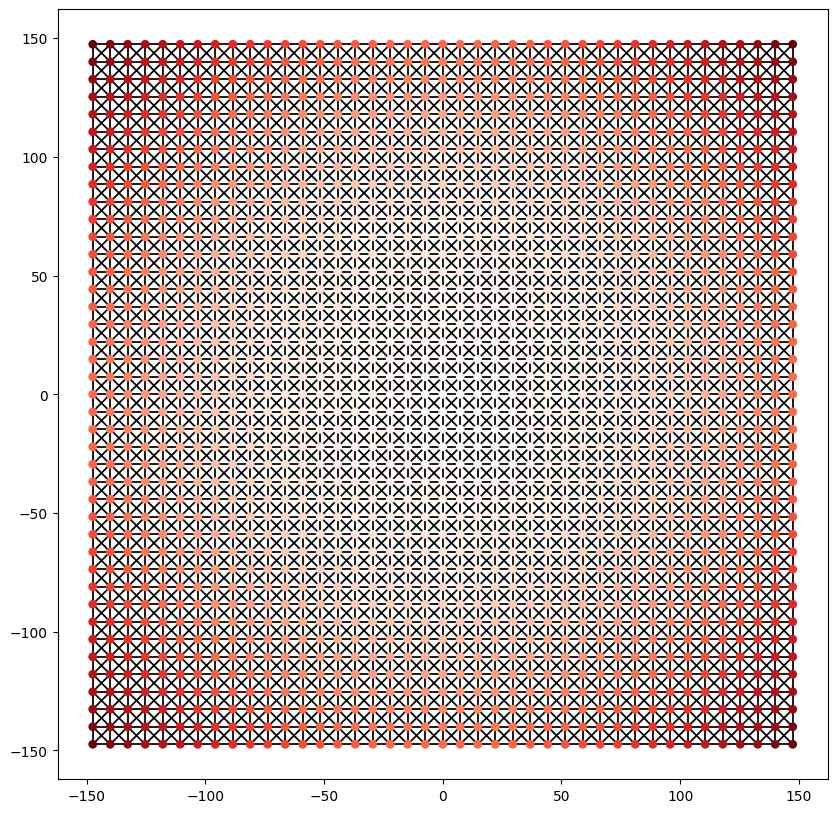

In [20]:
sys = make_lao_sto_qd(qd_data, qd_numerical_params)
plot = kwant.plot(
    sys,
    show=False,
    site_color=lambda site: np.abs(sys.hamiltonian(site, site)[0, 0]),
    fig_size=(10, 10),
    colorbar=False,
    cmap="Reds",
)
plt.show()

In [21]:
hamiltonian = sys.hamiltonian_submatrix(sparse=True)
n_values = 4
E, vecs = scipy.sparse.linalg.eigsh(
    hamiltonian, n_values, ncv=10 * n_values + 10, sigma=0
)
print(np.sort(np.real(E) / eV2au(1.0) * 1e3))

[-10.50483447 -10.50483447  19.27506928  19.27506928]


In [22]:
np.set_printoptions(threshold=np.inf)
ham = sys.hamiltonian_submatrix(sparse=False)
# ham = np.transpose(ham)
for i in range(54):
    for j in range(54):
        print(i + 1, j + 1, ham[i, j])

1 1 (0.13862465847868025+0j)
1 2 0j
1 3 0j
1 4 0.00012249775290408077j
1 5 0j
1 6 (-0.00012249775290408077+0j)
1 7 (-0.0321556601373212-0j)
1 8 -0j
1 9 (0.0003674932587122423-0j)
1 10 -0j
1 11 -0j
1 12 -0j
1 13 0j
1 14 0j
1 15 0j
1 16 0j
1 17 0j
1 18 0j
1 19 0j
1 20 0j
1 21 0j
1 22 0j
1 23 0j
1 24 0j
1 25 0j
1 26 0j
1 27 0j
1 28 0j
1 29 0j
1 30 0j
1 31 0j
1 32 0j
1 33 0j
1 34 0j
1 35 0j
1 36 0j
1 37 0j
1 38 0j
1 39 0j
1 40 0j
1 41 0j
1 42 0j
1 43 0j
1 44 0j
1 45 0j
1 46 0j
1 47 0j
1 48 0j
1 49 0j
1 50 0j
1 51 0j
1 52 0j
1 53 0j
1 54 0j
2 1 0j
2 2 (0.13862465847868025+0j)
2 3 0.00012249775290408077j
2 4 0j
2 5 (0.00012249775290408077+0j)
2 6 0j
2 7 -0j
2 8 (-0.0321556601373212-0j)
2 9 -0j
2 10 (0.0003674932587122423-0j)
2 11 -0j
2 12 -0j
2 13 0j
2 14 0j
2 15 0j
2 16 0j
2 17 0j
2 18 0j
2 19 0j
2 20 0j
2 21 0j
2 22 0j
2 23 0j
2 24 0j
2 25 0j
2 26 0j
2 27 0j
2 28 0j
2 29 0j
2 30 0j
2 31 0j
2 32 0j
2 33 0j
2 34 0j
2 35 0j
2 36 0j
2 37 0j
2 38 0j
2 39 0j
2 40 0j
2 41 0j
2 42 0j
2 43 0j
2 44 